In [1]:
import torch
from torch import nn

from torch.utils.data import Dataset
from PIL import Image
import os
import torchvision.transforms as T

from torch.utils.data import DataLoader

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class CelebDataset(Dataset):
    def __init__(self, image_dir, img_transform=None):
        self.image_dir = image_dir
        self.img_transform = img_transform
        self.image_paths = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_paths[idx])
        image = Image.open(img_path).convert("RGB")

        if self.img_transform:
            image = self.img_transform(image)

        return image

In [3]:
img_transform = T.Compose([
    T.Resize((48, 48)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

train_dataset = CelebDataset(
    image_dir="img_align_celeba/img_align_celeba",
    img_transform=img_transform
)

test_dataset = CelebDataset(
    image_dir="test",
    img_transform=img_transform
)

train_loader = DataLoader(train_dataset, batch_size=4, num_workers=0, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

In [4]:
len(train_dataset)

202599

In [5]:
len(test_loader)

5000

In [6]:
class Generator(nn.Module):

    def __init__(self, z_dim=100, img_dim=6912):
        super().__init__()

        self.img_dim = img_dim
        self.z_dim = z_dim

        self.net = nn.Sequential(
            nn.Linear(z_dim, 500),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(500, img_dim),
            nn.Sigmoid()
        )
   

    def sample(self, batch_size=64, device="cpu"):
        z = torch.randn(batch_size, self.z_dim, device=device)

        return z
    
    def forward(self, z):
        x = self.net(z)

        return x

In [7]:
class Discriminator(nn.Module):
    def __init__(self, img_dim=6912):
        super().__init__()

        self.img_dim = img_dim
    
        self.net = nn.Sequential(
            nn.Linear(img_dim, 240),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.5),

            nn.Linear(240, 240),
            nn.LeakyReLU(0.2),
            nn.Dropout(p=0.5),

            nn.Linear(240, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x = x.view(x.size(0), -1)
        x = x.reshape(x.size(0), -1)
        return self.net(x)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
gen = Generator().to(device)

In [10]:
disc = Discriminator().to(device)

In [11]:
# LD​=−(logD(x)+log(1−D(G(z))))  >>> this is the original discriminator loss from the GAN paper.
# Now in PyTorch, instead of manually writing log() terms, people usually use nn.BCELoss() (binary cross entropy), which already implements
# BCE(p,y)=−(y⋅log(p)+(1−y)⋅log(1−p))

# For real images (y=1):

In [12]:
real_images = next(iter(train_loader))
print(real_images.shape)

torch.Size([4, 3, 48, 48])


In [13]:
real_images = next(iter(train_loader))
real_images = real_images.to(device)

In [14]:
real_images.shape

torch.Size([4, 3, 48, 48])

In [15]:
real_loss = -(1*torch.log(disc(real_images)) + (1-1)*torch.log(1-disc(real_images)+ 1e-8)).mean()  # −logD(x)
# LD​=−(logD(x)+log(1−D(G(z)))) above is for y=1

In [16]:
# For real images (y=0):

In [17]:
# z = torch.randn(batch_size, latent_dim).to(device)
z = gen.sample(batch_size=real_images.size(0), device=device)
fake_images = gen(z)
fake_images_reshaped = fake_images.view(-1, 3, 48, 48)

In [18]:
print(fake_images.shape)
print(fake_images_reshaped.shape)

torch.Size([4, 6912])
torch.Size([4, 3, 48, 48])


In [19]:
fake_loss = -(0*torch.log(disc(fake_images_reshaped)) + (1-0)*torch.log(1-disc(fake_images_reshaped)) + 1e-8).mean()

In [20]:
d_loss = real_loss + fake_loss

In [21]:
d_loss.shape

torch.Size([])

In [22]:
# for the generator loss
# LG​=−log(D(G(z)))

In [23]:
g_loss = -(torch.log(disc(fake_images_reshaped)) + 1e-8).mean()

In [24]:
optimizer_D = torch.optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_G = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [25]:
from tqdm.notebook import tqdm

num_epochs = 3
for epoch in range(num_epochs):
    epoch_loss_d = 0.0
    epoch_loss_g = 0.0

    # Wrap train_loader with tqdm
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=True)
    
    for real_images in loop:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Real images loss
        real_loss = -(1*torch.log(disc(real_images)) + (1-1)*torch.log(1-disc(real_images)) + 1e-8).mean()  

        z = gen.sample(batch_size=real_images.size(0), device=device)
        fake_images = gen(z)
        fake_images_reshaped = fake_images.view(-1, 3, 48, 48)
        fake_loss = -(0*torch.log(disc(fake_images_reshaped.detach())) + (1-0)*torch.log(1-disc(fake_images_reshaped.detach())) + 1e-8).mean()

        d_loss = real_loss + fake_loss
        
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        # Generator tries to fool discriminator
        g_loss = -(torch.log(disc(fake_images_reshaped)) + 1e-8).mean()
        g_loss.backward()
        optimizer_G.step()

        epoch_loss_d = epoch_loss_d + d_loss.item()
        epoch_loss_g = epoch_loss_g + g_loss.item()

        # Update tqdm description with losses
        loop.set_postfix(D_loss=epoch_loss_d/(loop.n+1), G_loss=epoch_loss_g/(loop.n+1))

    avg_loss_d = epoch_loss_d / len(train_loader)
    avg_loss_g = epoch_loss_g / len(train_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], D Loss: {avg_loss_d:.4f}, G Loss: {avg_loss_g:.4f}")

Epoch [1/3]:   0%|          | 0/50650 [00:00<?, ?it/s]

Epoch [1/3], D Loss: nan, G Loss: nan


Epoch [2/3]:   0%|          | 0/50650 [00:00<?, ?it/s]

Epoch [2/3], D Loss: nan, G Loss: nan


Epoch [3/3]:   0%|          | 0/50650 [00:00<?, ?it/s]

Epoch [3/3], D Loss: nan, G Loss: nan


In [26]:
torch.save(gen.state_dict(), "generator.pth")
torch.save(disc.state_dict(), "discriminator.pth")

In [27]:
torch.save({
    "optimizer_G_state_dict": optimizer_G.state_dict(),
    "optimizer_D_state_dict": optimizer_D.state_dict(),
    "epoch": epoch  # optional, for checkpointing
}, "gan_checkpoint.pth")

In [29]:
gen.load_state_dict(torch.load("generator.pth"))
disc.load_state_dict(torch.load("discriminator.pth"))

<All keys matched successfully>

In [42]:
gen = Generator(z_dim=100, img_dim=6912).to(device)
gen.load_state_dict(torch.load("generator.pth", map_location=device))
gen.eval()

Generator(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=500, out_features=6912, bias=True)
    (7): Sigmoid()
  )
)

In [46]:
disc

Discriminator(
  (net): Sequential(
    (0): Linear(in_features=6912, out_features=240, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=240, out_features=240, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=240, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [43]:
# batch_size = number of images you want to generate
z = gen.sample(batch_size=1, device=device)

In [44]:
with torch.no_grad():
    fake_image = gen(z)  # shape [1, 6912]

# Reshape back to image format [batch, channels, height, width]
fake_image = fake_image.view(1, 3, 48, 48)

C:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\transforms\functional.py:282: RuntimeWarning: invalid value encountered in cast
  npimg = (npimg * 255).astype(np.uint8)


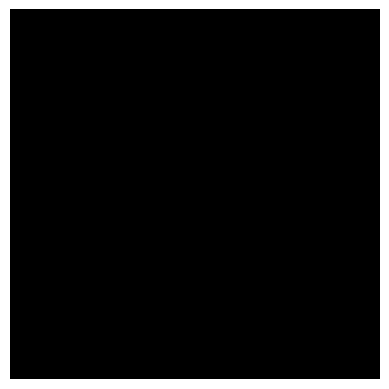

In [45]:
# Unnormalize (back to [0,1] range)
mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)

fake_image = fake_image * std + mean
fake_image = torch.clamp(fake_image, 0, 1)

# Convert to CPU numpy for plotting
import matplotlib.pyplot as plt
import torchvision.transforms as T

plt.imshow(T.ToPILImage()(fake_image.squeeze(0).cpu()))
plt.axis("off")
plt.show()

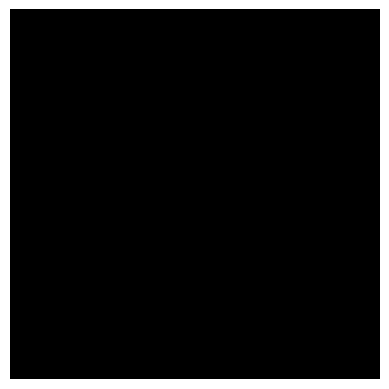

In [57]:
import torch
import matplotlib.pyplot as plt

# Load trained generator
gen = Generator()
gen.load_state_dict(torch.load("generator.pth", map_location="cpu"))
gen.eval()

# Generate noise
z = torch.randn(1, 100)  # batch=1, z_dim=100

# Generate fake image
with torch.no_grad():
    fake_img = gen(z)

# Reshape (assuming 48x48x3)
fake_img = fake_img.view(48, 48, 3).cpu().numpy()

# Plot
plt.imshow(fake_img)
plt.axis("off")
plt.show()

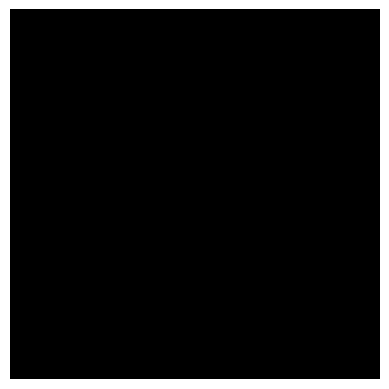

In [58]:
fake_img = gen(z).cpu().view(48, 48, 3).detach().numpy()

# Normalize for visualization
fake_img = (fake_img - fake_img.min()) / (fake_img.max() - fake_img.min() + 1e-8)

plt.imshow(fake_img)
plt.axis("off")
plt.show()